# Анализ текстов с помощью реккурентных нейронных сетей

В этой работе будет производится исследование тональности отзывов на фильмы датасета IMDb с помощью нейронной сети с долгой краткосрочной памятью (LSTM), которая является разновидностью реккурентных нейронных сетей (RNN). Суть исследования состоит в решении задачи бинарной классификации.

## Импорт модулей

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import time

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, SpatialDropout1D
from keras.preprocessing import sequence
from keras.datasets import imdb

Using Theano backend.


In [2]:
# Устанавливаем seed для повторяемости результатов
np.random.seed(42)

## Предобработка данных

Открытый набор данных:
- http://ai.stanford.edu/~amaas/data/sentiment/
  Andrew L. Maas, Raymond E. Daly, Peter T. Pham,
  Dan Huang, Andrew Y. Ng, Cristopher Potts (2011)
  Learning Word Vectors For Sentiment Analysis
  
Данные:
-  25000 рецензий для обучения
-  25000 рецензий для тестирования
  
Целевые метки классов:
-  1 - положительный отзыв
-  0 - негативный отзыв

In [4]:
# Максимальное количество слов (по частоте использования)
max_features = 5000

In [5]:
# Загружаем данные
(X_data, y_data), (X_test, y_test) = imdb.load_data(num_words = max_features)

In [6]:
# Разбиваем выборку на тренировочную и валидационную
X_train = X_data[:17000]
y_train = y_data[:17000]

X_val = X_data[17000:]
y_val = y_data[17000:]

In [7]:
print('Размер обучающей выборки', len(X_train))
print('Размер валидационной выборки', len(X_val))
print('Размер тестовой выборки', len(X_test))

Размер обучающей выборки 17000
Размер валидационной выборки 8000
Размер тестовой выборки 25000


In [8]:
# Максимальная длина рецензии в словах
maxlen = 80

In [9]:
# Заполняем или обрезаем рецензии (приводим тексты к одинаковой длине)
X_train = sequence.pad_sequences(X_train, maxlen = maxlen)
X_val = sequence.pad_sequences(X_val, maxlen = maxlen)
X_test = sequence.pad_sequences(X_test, maxlen = maxlen)

## Реккурентная нейронная сеть LSTM

Архитектура сети:
- Слой векторного представления слов
- Слой LSTM
- Полносвязный слой для классификации

In [10]:
# Создаем сеть
model = Sequential()

In [11]:
# Слой для векторного представления слов
model.add(Embedding(max_features, 32))
model.add(SpatialDropout1D(0.2))

In [12]:
# Слой долго-краткосрочной памяти
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))

In [13]:
# Полносвязный слой
model.add(Dense(1, activation="sigmoid"))

### Полная информация об архитектуре сети

In [14]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Копмилируем модель
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Обучение нейронной сети

In [16]:
%%time
# Обучаем модель
history = model.fit(X_train,
                    y_train,
                    batch_size = 64,
                    epochs = 2,
                    validation_data = (X_val, y_val),
                    verbose = 1)

Train on 17000 samples, validate on 8000 samples
Epoch 1/2
17000/17000 [==============================] - 313s 18ms/step - loss: 0.5038 - acc: 0.7384 - val_loss: 0.3800 - val_acc: 0.8280
Epoch 2/2
17000/17000 [==============================] - 336s 20ms/step - loss: 0.3302 - acc: 0.8631 - val_loss: 0.3812 - val_acc: 0.8343
Wall time: 11min 36s


## Визуализация процесса обучения нейронной сети

In [21]:
import matplotlib.pyplot as plt

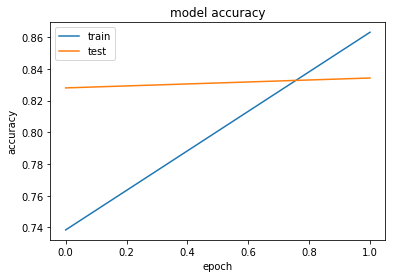

In [22]:
# График точности при обучении
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

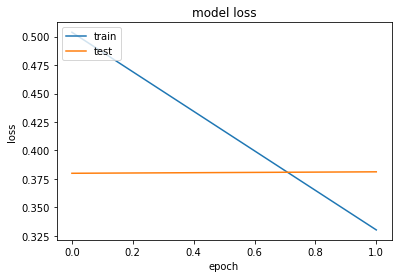

In [23]:
# График потерь при обучении
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Оценка качества обучения нейронной сети

In [24]:
%%time
# Оценка качества обучения на тестовых данных
scores = model.evaluate(X_test,
                        y_test,
                        batch_size = 64,
                        verbose = 1)

25000/25000 [==============================] - 146s 6ms/step
Wall time: 2min 25s


In [25]:
print("Точность на тестовых данных: %.2f%%" % (scores[1] * 100))

Точность на тестовых данных: 83.54%
